In [8]:
import pandas as pd

In [9]:
vul_data = pd.read_csv("./../vulnerability/cargo_vul_data.csv",delimiter=",")
vul_data

,vulnerability_name,package_name,version_range,published_at,project_id
0,Integer Overflow in Chunked Transfer-Encoding,hyper,>=0 <0.14.10,2021-07-12T16:55:37Z,31056
1,Lenient Parsing of Content-Length Header When ...,hyper,>=0 <0.14.10,2021-07-12T16:54:20Z,31056
2,SMTP command injection in lettre,lettre,>=0.7.0 <0.9.6,2021-07-12T17:03:27Z,1056639
3,Link following in tar,tar,>=0 <0.4.16,2021-08-25T20:43:54Z,31448
4,Data races in rusqlite,rusqlite,>=0 <0.23.0,2021-08-25T20:47:57Z,31334
...,...,...,...,...,...
382,Cap'n Proto and its Rust implementation vulner...,capnp,>=0.15.0 <0.15.2 || >=0.14.0 <0.14.11 || >=0.1...,2022-12-05T17:58:16Z,30819
383,Tokio reject_remote_clients configuration may ...,tokio,>=1.7.0 <1.18.4 || >=1.19.0 <1.20.3 || >=1.7.0...,2023-01-06T21:40:58Z,1563316
384,bzip2 allows attackers to cause a denial of se...,bzip2,>=0 <0.4.4,2023-01-10T03:30:29Z,30815
385,webbrowser-rs allows attackers to access arbit...,webbrowser,>=0 <0.8.3,2023-01-13T21:30:26Z,1114327


In [10]:
vul_data = pd.read_csv("./affected_packages_cargo_with_all.csv",delimiter=",")

In [11]:
vul_data.groupby("vul_project_id").size()

vul_project_id
30774       311
30815        44
30819        28
30838      1915
30851         4
           ... 
4333299       1
4565296       3
4576675       8
4613364       1
4721836       1
Length: 183, dtype: int64

In [12]:
vul_data["vul_months"] = (vul_data["vul_end_timestamp"] - vul_data["vul_start_timestamp"]) / (3600 * 24 * 30)

In [13]:
vul_data.query('compliantType == 2 and vul_end_timestamp < 1674091000').loc[:,["project_id", "vul_project_id","vul_start_datetime","vul_end_datetime", "vul_start_dependency_compliant","vul_months", 'compliantType']]

,project_id,vul_project_id,vul_start_datetime,vul_end_datetime,vul_start_dependency_compliant,vul_months,compliantType


<AxesSubplot: >

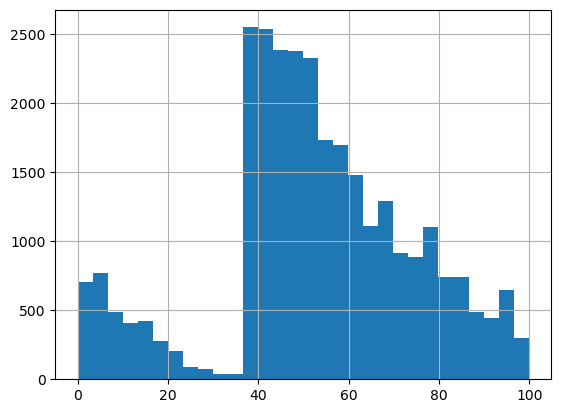

In [14]:
vul_data["vul_months"].hist(bins=30)

In [15]:
vul_data.groupby("compliantType").size()

compliantType
1     1524
2        1
3       39
4      199
5    27491
dtype: int64

# サバイバル分析

In [16]:
from sksurv.nonparametric import kaplan_meier_estimator
import matplotlib.pyplot as plt

In [17]:
vul_data_compliant = vul_data[vul_data["compliantType"] == 1]
vul_data_permissive = vul_data[vul_data["compliantType"] == 2]
vul_data_restrictive = vul_data[vul_data["compliantType"] == 3]

In [18]:
status = vul_data["vul_end_timestamp"] < 1674091000

In [19]:
status

0        False
1        False
2        False
3        False
4        False
         ...  
29249    False
29250    False
29251    False
29252    False
29253    False
Name: vul_end_timestamp, Length: 29254, dtype: bool

In [20]:
vul_data_compliant["vul_months"].describe()

count    1524.000000
mean       45.455935
std        11.906501
min         0.064315
25%        40.272367
50%        45.389683
75%        51.115424
max        93.490154
Name: vul_months, dtype: float64

In [21]:
vul_data_permissive["vul_months"].describe()

count     1.000000
mean     47.415613
std            NaN
min      47.415613
25%      47.415613
50%      47.415613
75%      47.415613
max      47.415613
Name: vul_months, dtype: float64

In [22]:
vul_data_restrictive["vul_months"].describe()

count    39.000000
mean     41.930164
std      13.430729
min       0.235145
25%      39.436537
50%      40.314731
75%      50.419124
max      77.703414
Name: vul_months, dtype: float64

Text(0.5, 0, 'time $t$')

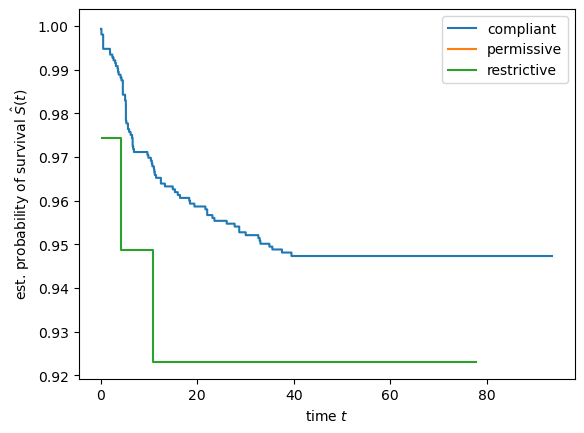

In [23]:
time_compliant, survival_prob_compliant = kaplan_meier_estimator(vul_data_compliant["vul_end_timestamp"] < 1674091000, vul_data_compliant["vul_months"])
time_permissive, survival_prob_permissive = kaplan_meier_estimator(vul_data_permissive["vul_end_timestamp"] < 1674091000, vul_data_permissive["vul_months"])
time_restrictive, survival_prob_restrictive = kaplan_meier_estimator(vul_data_restrictive["vul_end_timestamp"] < 1674091000, vul_data_restrictive["vul_months"])

plt.step(time_compliant, survival_prob_compliant, where="post", label="compliant")
plt.step(time_permissive, survival_prob_permissive, where="post", label="permissive")
plt.step(time_restrictive, survival_prob_restrictive, where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

## 生存分析(打ち切りなしver)

Text(0.5, 0, 'time $t$')

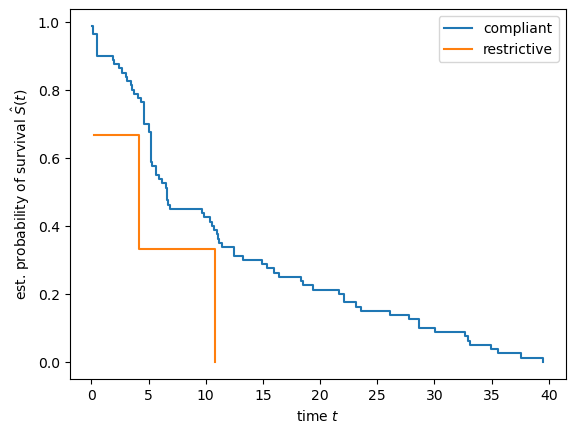

In [25]:
time_compliant, survival_prob_compliant = kaplan_meier_estimator(vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_end_timestamp"] < 1674091000, vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_months"])

# time_permissive, survival_prob_permissive = kaplan_meier_estimator(vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_end_timestamp"] < 1674091000, vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_months"])
time_restrictive, survival_prob_restrictive = kaplan_meier_estimator(vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_end_timestamp"] < 1674091000, vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_months"])

plt.step(time_compliant, survival_prob_compliant, where="post", label="compliant")
# plt.step(time_permissive, survival_prob_permissive, where="post", label="permissive")
plt.step(time_restrictive, survival_prob_restrictive, where="post", label="restrictive")

plt.legend()

plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")

<AxesSubplot: >

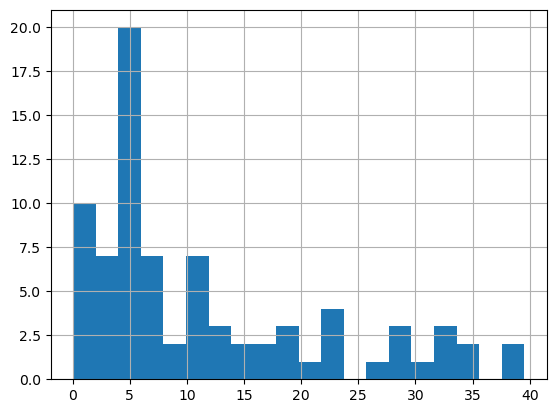

In [34]:
vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_months"].hist(bins=20)

<AxesSubplot: >

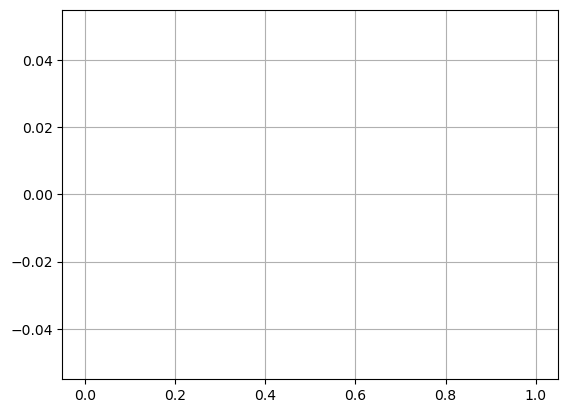

In [27]:
vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_months"].hist(bins=50)

<AxesSubplot: >

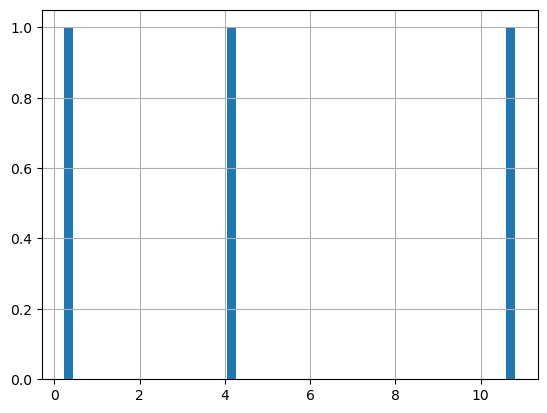

In [28]:
vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_months"].hist(bins=50)

In [29]:
vul_data_compliant[vul_data_compliant["vul_end_timestamp"] < 1674091000]["vul_months"].describe()

count    80.000000
mean     11.600467
std      10.618176
min       0.064315
25%       4.574952
50%       6.603447
75%      16.902317
max      39.509550
Name: vul_months, dtype: float64

In [30]:
vul_data_permissive[vul_data_permissive["vul_end_timestamp"] < 1674091000]["vul_months"].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: vul_months, dtype: float64

In [31]:
vul_data_restrictive[vul_data_restrictive["vul_end_timestamp"] < 1674091000]["vul_months"].describe()

count     3.000000
mean      5.062347
std       5.347902
min       0.235145
25%       2.187939
50%       4.140733
75%       7.475947
max      10.811161
Name: vul_months, dtype: float64